## Swiss bank bill data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import sklearn

### Import dataset from the url

In [2]:
import urllib.request

url = 'https://raw.githubusercontent.com/maskot1977/ipython_notebook/master/toydata/sbnote_dataJt.txt'

urllib.request.urlretrieve(url, 'swiss_bill.txt')

df = pd.read_csv('swiss_bill.txt', sep='\t', index_col=0)
df

,length,left,right,bottom,top,diagonal,class
Note,,,,,,,
1,214.8,131.0,131.1,9.0,9.7,141.0,0
2,214.6,129.7,129.7,8.1,9.5,141.7,0
3,214.8,129.7,129.7,8.7,9.6,142.2,0
4,214.8,129.7,129.6,7.5,10.4,142.0,0
5,215.0,129.6,129.7,10.4,7.7,141.8,0
...,...,...,...,...,...,...,...
196,215.0,130.4,130.3,9.9,12.1,139.6,1
197,215.1,130.3,129.9,10.3,11.5,139.7,1
198,214.8,130.3,130.4,10.6,11.1,140.0,1


In [3]:
df.iloc[:,:-1].describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,length,left,right,bottom,top,diagonal
count,200,200,200,200,200,200
mean,214.901,130.122,129.957,9.418,10.6505,140.483
std,0.380556,0.361026,0.404072,1.44392,0.802947,1.15227
min,213.8,129,129,7.2,7.7,137.8
25%,214.6,129.9,129.7,8.2,10.1,139.5
50%,214.9,130.2,130,9.1,10.6,140.45
75%,215.1,130.4,130.225,10.6,11.2,141.5
max,216.3,131,131.1,12.7,12.3,142.4


### Principal Component Analysis (PCA)

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Drop the column 'class'.

df_2 = df.copy()
df_2.drop(columns='class', inplace=True)


# Standardize data.

std_sc = StandardScaler()
std_data = std_sc.fit_transform(df_2)
std_data_df = pd.DataFrame(std_data, columns=df_2.columns)

# Execute PCA.

pca = PCA()

pca_cor = pca.fit_transform(std_data_df)

# pca.get_covariance()

In [5]:
# Eigenvalue vector

print('Eigenvalue vector')
eig_vec = pd.DataFrame(pca.components_.T, index=std_data_df.columns, 
                       columns = ['PC{}'.format(x+1) for x in range(len(std_data_df.columns))])
eig_vec

Eigenvalue vector


,PC1,PC2,PC3,PC4,PC5,PC6
length,-0.002039,0.813181,-0.024897,-0.578184,-0.058267,0.020532
left,-0.468708,0.339587,0.090792,0.400364,0.641084,-0.292353
right,-0.487349,0.254235,0.113466,0.428824,-0.615030,0.350470
bottom,-0.405921,-0.261830,0.594312,-0.387507,-0.213116,-0.466783
top,-0.367724,-0.111525,-0.783853,-0.114675,-0.218917,-0.420523
diagonal,0.492754,0.278908,0.103102,0.397755,-0.337656,-0.629724


In [6]:
# Eigenvalue

eig = pd.DataFrame(pca.explained_variance_, index=['PC{}'.format(x+1) for x in range(len(std_data_df.columns))], columns=['Eigenvalue']).T
eig

,PC1,PC2,PC3,PC4,PC5,PC6
Eigenvalue,2.960011,1.293063,0.872803,0.443978,0.27013,0.190166


In [7]:
# Standard deviation

dv = np.sqrt(eig)

dv =dv.rename(index={'Eigenvalue':'Standard deviation'})
dv

,PC1,PC2,PC3,PC4,PC5,PC6
Standard deviation,1.720468,1.137129,0.934239,0.666317,0.51974,0.436081


In [8]:
# Contribution rate

ev = pd.DataFrame(pca.explained_variance_ratio_, index=['PC{}'.format(x+1) for x in range(len(std_data_df.columns))], columns=['Contribution rate']).T
ev

,PC1,PC2,PC3,PC4,PC5,PC6
Contribution rate,0.490868,0.214433,0.14474,0.073626,0.044797,0.031536


In [9]:
# Culmulated contribution rate

t_ev = pd.DataFrame(pca.explained_variance_ratio_.cumsum(), index=['PC{}'.format(x+1) for x in range(len(std_data_df.columns))], columns=['Culmulated contribution rate']).T
t_ev

,PC1,PC2,PC3,PC4,PC5,PC6
Culmulated contribution rate,0.490868,0.705301,0.850041,0.923667,0.968464,1.0


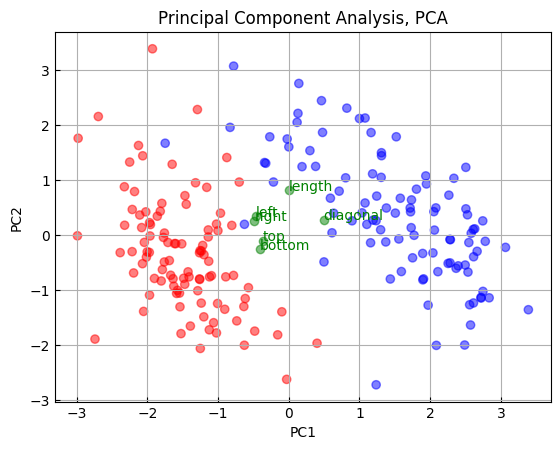

In [10]:
color_codes = {0:'#0000FF', 1:'#FF0000'}
colors = [color_codes[x] for x in df['class'].tolist()]

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.figure()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Principal Component Analysis, PCA')
plt.grid()

plt.scatter(pca_cor[:,0], pca_cor[:,1], color=colors, alpha=0.5)

for x, y, name in zip(pca.components_[0], pca.components_[1], std_data_df.columns):
    plt.text(x, y, name, color='g')
plt.scatter(pca.components_[0], pca.components_[1], alpha=0.5, color='g')

    


### Conclusion

According to the cumulated contribution rate, first and second components contribute more than 70 % of all components. That 's why the these components can distinguish the real from fake bills. As you can see in the scattering graph, PC1 and PC2 can actually divide correct class well.

## Logistic Regression

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [12]:
X = std_data_df.copy()
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

In [13]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

# The accuracy of training data.
clf.score(X_train, y_train)

0.9916666666666667

In [14]:
# The accuracy of test data.
clf.score(X_test, y_test)

1.0

In [15]:
y_predict = clf.predict(X_test)
# pd.DataFrame(y_predict).T

# Confusion matrix
pd.DataFrame(confusion_matrix(y_predict, y_test), index=['predicted 0', 'predicted 1'], columns=['real 0', 'real 1'])

,real 0,real 1
predicted 0,35,0
predicted 1,0,45
